In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [2]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [4]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [5]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [6]:
X_with_target = data.copy()

{col: X_with_target.groupby(col)['selling_price'].mean() + 0.006 * np.random.normal()
                    for col in object_cols}

{'name': name
 Ambassador CLASSIC 1500 DSL AC          1.200000e+05
 Ambassador Classic 2000 Dsz             5.000000e+04
 Ambassador Grand 1800 ISZ MPFI PW CL    4.300000e+05
 Audi A4 1.8 TFSI                        1.200000e+06
 Audi A4 2.0 TDI                         1.295000e+06
                                             ...     
 Volkswagen Vento Petrol Highline AT     2.845000e+05
 Volvo V40 D3 R Design                   1.975000e+06
 Volvo XC 90 D5 Inscription BSIV         4.500000e+06
 Volvo XC60 D3 Kinetic                   1.750000e+06
 Volvo XC60 D5 Inscription               2.000000e+06
 Name: selling_price, Length: 1491, dtype: float64,
 'year': year
 1992    5.000000e+04
 1995    9.500000e+04
 1996    2.250000e+05
 1997    9.300000e+04
 1998    2.140000e+05
 1999    7.350000e+04
 2000    8.150000e+04
 2001    1.176499e+05
 2002    9.071429e+04
 2003    8.656522e+04
 2004    1.217500e+05
 2005    1.090130e+05
 2006    1.577999e+05
 2007    1.628284e+05
 2008    1.742013e

In [7]:
data.isna().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric, target_col='selling_price'):
        self.categorical = categorical
        self.numeric = numeric
        self.target_col = target_col
        
    def fit(self, X, y):
        
        X_fit = X.copy()
        y_fit = y.copy()
        
        # Определили числовые колонки
        # self.numeric_cols = [col for col in X_fit.columns if col not in self.categorical]
        
        # Объединяем с таргетом
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        # Создаем словарь, каждый элемент которого - колонка (ключ) и серия с зашумленным значением таргета (значение)
        self.mte_dict = {col: X_with_target.groupby(col)[self.target_col].mean() + 0.006 * np.random.normal()
                         for col in self.categorical}
        
        # Список всех колонок с mte
        self.mte_cols = self.mte_dict.keys()
        
        return self
        
    def transform(self, df):
        
        X_ = df.copy()
        
        for col in self.categorical:
            X_[col] = X_[col].map(self.mte_dict[col])
            X_[col] = X_[col].fillna(0)
        
        return X_

In [9]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.478865,13.435892,50000,13.085954,12.611658,13.776443,12.959126
2290,12.125200,11.906484,70000,12.450179,12.611658,13.776443,12.959126
874,12.311508,13.333058,50000,12.450179,12.611658,12.643381,12.959126
1907,12.493842,13.053677,92198,12.450179,13.140882,12.643381,12.446379
3244,12.401697,12.857085,3240,12.450179,12.611658,12.643381,12.446379


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [10]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [11]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

score_list_depth = []

for depth in max_depth_list:
    
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                     ('dt', DecisionTreeRegressor(max_depth=depth))])
    pipe.fit(X_train, y_train)
    
    score_list_depth.append(np.mean((pipe.predict(X_test) - y_test) ** 2))

In [12]:
score_list_depth

[0.7968292144891994, 1.441863393873008, 1.9886790473777394, 1.9831678836075346]

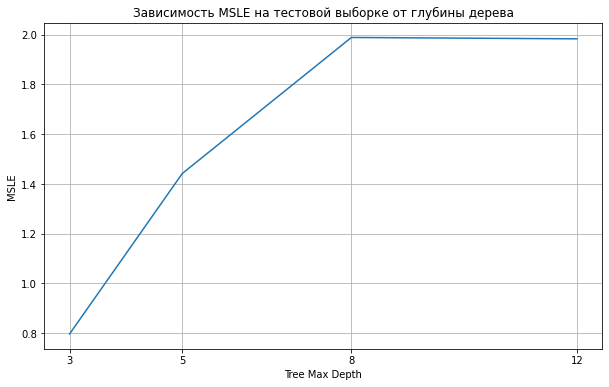

In [13]:
fig = plt.figure(figsize=(10, 6))

plt.plot(max_depth_list, score_list_depth)
plt.title('Зависимость MSLE на тестовой выборке от глубины дерева')
plt.xlabel('Tree Max Depth')
plt.ylabel('MSLE')
plt.xticks(max_depth_list)
plt.grid()
plt.show()

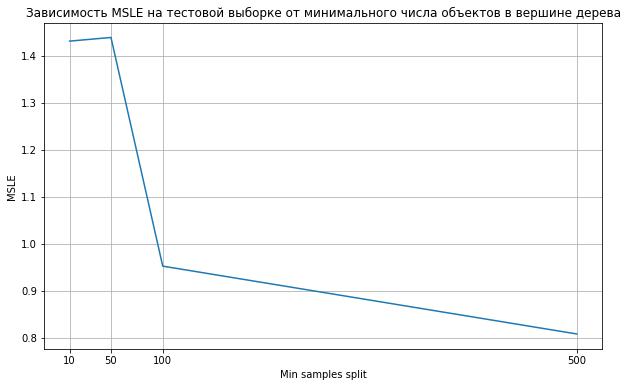

In [14]:
score_list_samples_split = []

for samples in min_samples_split_list:
    
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                     ('dt', DecisionTreeRegressor(min_samples_split=samples))])
    pipe.fit(X_train, y_train)
    
    score_list_samples_split.append(np.mean((pipe.predict(X_test) - y_test) ** 2))
    
fig = plt.figure(figsize=(10, 6))

plt.plot(min_samples_split_list, score_list_samples_split)
plt.title('Зависимость MSLE на тестовой выборке от минимального числа объектов в вершине дерева')
plt.xlabel('Min samples split')
plt.ylabel('MSLE')
plt.xticks(min_samples_split_list)
plt.grid()
plt.show()

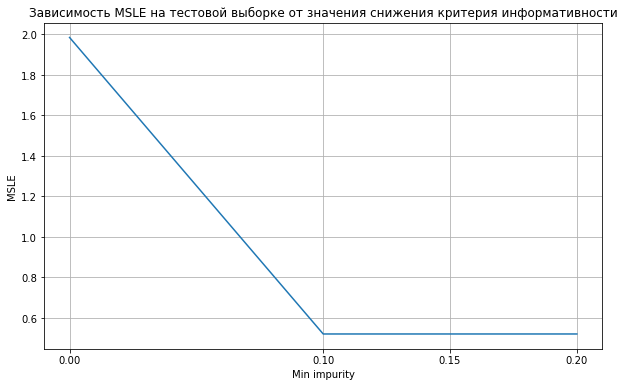

In [15]:
score_list_decreace = []

for decrease in min_impurity_decrease_list:
    
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                     ('dt', DecisionTreeRegressor(min_impurity_decrease=decrease))])
    pipe.fit(X_train, y_train)
    
    score_list_decreace.append(np.mean((pipe.predict(X_test) - y_test) ** 2))
    
fig = plt.figure(figsize=(10, 6))

plt.plot(min_impurity_decrease_list, score_list_decreace)
plt.title('Зависимость MSLE на тестовой выборке от значения снижения критерия информативности')
plt.xlabel('Min impurity')
plt.ylabel('MSLE')
plt.xticks(min_impurity_decrease_list)
plt.grid()
plt.show()

In [16]:
min(score_list_decreace)

0.5204871413036622

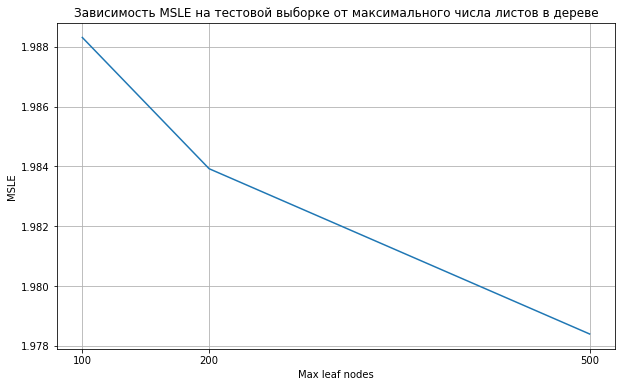

In [17]:
score_list_leaf_nodes = []

for leaf_nodes in max_leaf_nodes_list:
    
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                     ('dt', DecisionTreeRegressor(max_leaf_nodes=leaf_nodes))])
    pipe.fit(X_train, y_train)
    
    score_list_leaf_nodes.append(np.mean((pipe.predict(X_test) - y_test) ** 2))
    
fig = plt.figure(figsize=(10, 6))

plt.plot(max_leaf_nodes_list, score_list_leaf_nodes)
plt.title('Зависимость MSLE на тестовой выборке от максимального числа листов в дереве')
plt.xlabel('Max leaf nodes')
plt.ylabel('MSLE')
plt.xticks(max_leaf_nodes_list)
plt.grid()
plt.show()

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [18]:
pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   MeanTargetEncoderNoise(categorical=['name', 'year', 'fuel', 'seller_type',
                                       'transmission', 'owner'],
                          numeric=['km_driven'])),
  ('dt', DecisionTreeRegressor(max_leaf_nodes=500))],
 'verbose': False,
 'transformer': MeanTargetEncoderNoise(categorical=['name', 'year', 'fuel', 'seller_type',
                                     'transmission', 'owner'],
                        numeric=['km_driven']),
 'dt': DecisionTreeRegressor(max_leaf_nodes=500),
 'transformer__categorical': ['name',
  'year',
  'fuel',
  'seller_type',
  'transmission',
  'owner'],
 'transformer__numeric': ['km_driven'],
 'transformer__target_col': 'selling_price',
 'dt__ccp_alpha': 0.0,
 'dt__criterion': 'squared_error',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': 500,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_f

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "dt__max_depth": [3, 5, 8, 12],
    "dt__min_samples_split": [10, 50, 100, 500],
    "dt__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "dt__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                 ('dt', DecisionTreeRegressor())])


search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('dt', DecisionTreeRegressor())]),
             param_grid={'dt__max_depth': [3, 5, 8, 12],
                         'dt__max_leaf_nodes': [100, 200, 500],
                         'dt__min_impurity_decrease': [0, 0.1, 0.15, 0.2],
                         'dt__min_samples_split': [10, 50, 100, 50

In [20]:
search.best_params_

{'dt__max_depth': 8,
 'dt__max_leaf_nodes': 500,
 'dt__min_impurity_decrease': 0.1,
 'dt__min_samples_split': 50}

In [21]:
search.score(X_test, y_test)

-0.520487141303668